(0.2, 1.1)

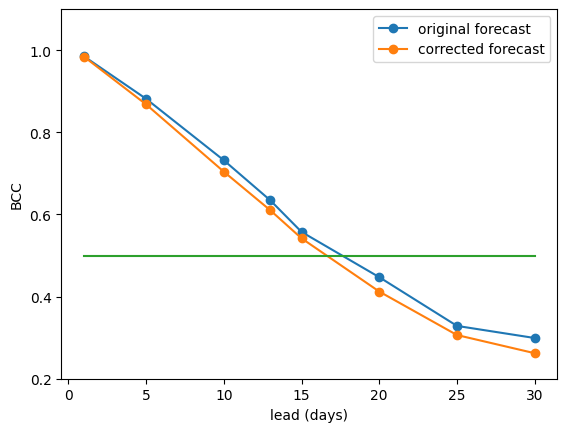

In [1]:
import numpy as np 
import xarray as xr 

nmem=300
noutputmem=1
nmemUnet=1
nvar = 3 
normflg = 1

BCCo = []
BCCc = []

lead = [1, 5, 10, 13, 15, 20, 25, 30]

for leadmjo in lead:
    datesta = np.datetime64(str(2015)) + np.timedelta64(nmem-1+nmemUnet-1+2*leadmjo,'D')
    dateend = np.datetime64(str(2018)+'-12-31') + np.timedelta64(nmem-2+leadmjo,'D')

    # read residual at t+lead
    fnr = '/global/homes/l/linyaoly/ERA5/script/Unet4MJO/Residual/output/residual_MCDO_UNET_'+str(nvar)+'vari_RMMERA5_36yr_lead'+str(leadmjo)+'_norm'+str(normflg)+'_dailyinput_nmem'+str(nmem)+'nout'+str(noutputmem)+'d.nc'
    dsr = xr.open_dataset(fnr)
    # slice the testing data
    dsr1 = dsr.loc[dict(time=slice(datesta, dateend))]
    resi1 = dsr1['resi'][:,0].values
    resi2 = dsr1['resi'][:,1].values 


    # read predicted RMM at t+lead
    fnp = '/global/homes/l/linyaoly/ERA5/reanalysis/'+'predicted_MCDO_UNET_19mapstrop_RMMERA5_36yr_lead'+str(leadmjo)+'_dailyinput_mem1d.nc'
    dsp = xr.open_dataset(fnp)
    dsp['RMM'] = dsp['__xarray_dataarray_variable__']
    dsp = dsp.drop(['__xarray_dataarray_variable__'])
    # slice the testing data
    dsp1 = dsp.loc[dict(time=slice(datesta - np.timedelta64(leadmjo,'D'), dateend - np.timedelta64(leadmjo,'D')))]
    RMMp1 = dsp1['RMM'][:,0].values  # (day)
    RMMp2 = dsp1['RMM'][:,1].values  # (day)


    # read the truth data at t+lead 
    fnt = '/global/homes/l/linyaoly/ERA5/reanalysis/RMM_ERA5_daily.nc'
    dst = xr.open_dataset(fnt)
    # slice the training data
    dst1 = dst.loc[dict(time=slice(datesta, dateend))]
    RMMt1 = dst1['RMM'][:,0].values  # (day)
    RMMt2 = dst1['RMM'][:,1].values  # (day)

    # corrected data
    RMMpc1 = RMMp1 + resi1
    RMMpc2 = RMMp2 + resi2

    a = sum(RMMp1*RMMt1+RMMp2*RMMt2)
    b = np.sqrt(sum(RMMt1*RMMt1+RMMt2*RMMt2))
    c = np.sqrt(sum(RMMp1*RMMp1+RMMp2*RMMp2))
    BCCo.append(a/b/c) 

    a = sum(RMMpc1*RMMt1+RMMpc2*RMMt2)
    b = np.sqrt(sum(RMMt1*RMMt1+RMMt2*RMMt2))
    c = np.sqrt(sum(RMMpc1*RMMpc1+RMMpc2*RMMpc2))
    BCCc.append(a/b/c) 

import matplotlib.pyplot as plt 

plt.plot(lead, BCCo, 'o-', label='original forecast')
plt.plot(lead, BCCc, 'o-', label='corrected forecast')
plt.plot(lead, 0.5 * np.ones(len(lead)))
plt.legend()

plt.xlabel('lead (days)')
plt.ylabel('BCC')
plt.ylim([0.2,1.1])

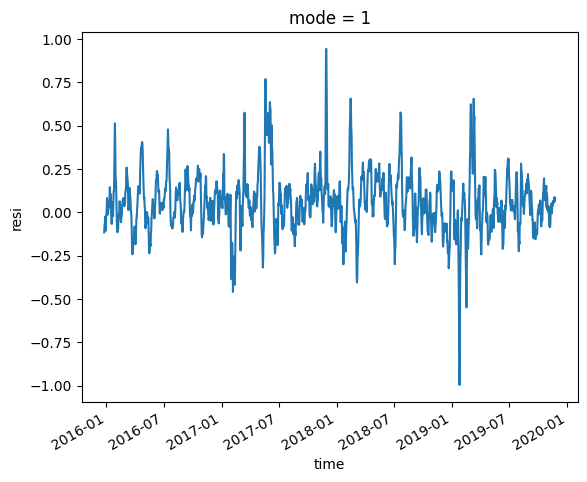

In [2]:
dsr1['resi'][:,1].plot()